In [1]:
%pip install --quiet -U langgraph langchain_groq langgraph_sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 18.6 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
apikey = userdata.get('GROQ_API_KEY')

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model= 'llama-3.3-70b-versatile', temperature = 0, api_key=apikey)

In [4]:
from langchain_core.tools import tool

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools: list[tool] = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

In [5]:
from langgraph.prebuilt import tools_condition, ToolNode

ToolNode

langgraph.prebuilt.tool_node.ToolNode

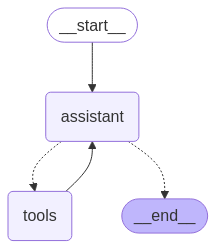

In [6]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph.state import CompiledStateGraph

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vg7y)
 Call ID: call_vg7y
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Browsing History


In [8]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5b04c2cd-0a7b-4ac3-8cad-0ed0d0c83efb'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vg7y', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 371, 'total_tokens': 390, 'completion_time': 0.069090909, 'prompt_time': 0.02399599, 'queue_time': 0.10130683500000001, 'total_time': 0.093086899}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_90c1d253ff', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9931a581-b274-41f4-9074-bc056dbc7ee8-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_vg7y', 'type': 'tool_call'}], usage_metadata={'input_tokens': 371, 'output_tokens': 19, 'total_tokens': 390}), ToolMessage(content='6', name='multiply', id='584679d8-7601-413e-8938-0f093218a754',

In [9]:
all_states = [s for s in graph.get_state_history(thread)]

In [10]:
len(all_states)

5

In [11]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5b04c2cd-0a7b-4ac3-8cad-0ed0d0c83efb')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f00cc0f-7615-6209-8000-61fb520ad7a7'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-03-29T17:12:17.208944+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f00cc0f-75f0-6c22-bfff-8692aced800e'}}, tasks=(PregelTask(id='e15994ea-759f-7384-a36d-153287a93ec0', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vg7y', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 371, 

Replaying


In [12]:
to_replay = all_states[-2]

In [13]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5b04c2cd-0a7b-4ac3-8cad-0ed0d0c83efb')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f00cc0f-7615-6209-8000-61fb520ad7a7'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2025-03-29T17:12:17.208944+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f00cc0f-75f0-6c22-bfff-8692aced800e'}}, tasks=(PregelTask(id='e15994ea-759f-7384-a36d-153287a93ec0', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vg7y', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 371, 

In [14]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5b04c2cd-0a7b-4ac3-8cad-0ed0d0c83efb')]}

In [15]:
to_replay.next

('assistant',)

In [16]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00cc0f-7615-6209-8000-61fb520ad7a7'}}

In [17]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3mpj)
 Call ID: call_3mpj
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Forking

In [18]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5b04c2cd-0a7b-4ac3-8cad-0ed0d0c83efb')]

In [19]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00cc0f-7615-6209-8000-61fb520ad7a7'}}

In [20]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3',
                               id=to_fork.values["messages"][0].id)]},
)

In [21]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00cc14-f464-651f-8001-7379fe017173'}}

In [22]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5b04c2cd-0a7b-4ac3-8cad-0ed0d0c83efb')]

In [23]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5b04c2cd-0a7b-4ac3-8cad-0ed0d0c83efb')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f00cc14-f464-651f-8001-7379fe017173'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5b04c2cd-0a7b-4ac3-8cad-0ed0d0c83efb')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1f00cc0f-7615-6209-8000-61fb520ad7a7'}, created_at='2025-03-29T17:14:44.671169+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f00cc0f-7615-6209-8000-61fb520ad7a7'}}, tasks=(PregelTask(id='4718784e-8fe6-e02d-9218-83c978e8779b', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [24]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3jbb)
 Call ID: call_3jbb
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


In [25]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5b04c2cd-0a7b-4ac3-8cad-0ed0d0c83efb'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3jbb', 'function': {'arguments': '{"a": 5, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 371, 'total_tokens': 390, 'completion_time': 0.069090909, 'prompt_time': 0.023998461, 'queue_time': 0.10104147399999999, 'total_time': 0.09308937}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_90c1d253ff', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1dda3870-1070-46b9-bb11-8fc2a9cd8767-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_3jbb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 371, 'output_tokens': 19, 'total_tokens': 390}), ToolMessage(content='15', name='multiply', id='5ffb0f24-a526-48b6-bcf2-8df9364dd578'